<a href="https://colab.research.google.com/github/Benjamin025/Benjamin025/blob/main/TSP_For_Rwanda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Author: Karanja Benjamin Ndung'u
## ENC222-0198/2021
## Geospatial Information Science

In [1]:
# Installing necessary packages
!pip install geopandas ortools networkx matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-datastore 2.19.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
google-cloud-firestore 2.16.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!

In [2]:
# Import required libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from shapely.geometry import Point

In [3]:
# Load the Rwanda boundary shapefile
rwanda_boundary = gpd.read_file("/content/Rwanda boundary/rwa_adm2_2006_NISR_WGS1984_20181002.shp")

# Load the towns shapefile
towns = gpd.read_file("/content/Rwanda towns/Rwnda towns.shp")


In [4]:
# CRS (WGS 84 - EPSG:4326) for both datasets
rwanda_boundary = rwanda_boundary.to_crs(epsg=4326)
towns = towns.to_crs(epsg=4326)

In [5]:
# Extract the coordinates of the towns as a NumPy array
town_coords = np.array(list(towns.geometry.apply(lambda point: (point.x, point.y))))


In [6]:
# Compute the Haversine distance
def haversine_distance(coord1, coord2):
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r


In [7]:
# Build the distance matrix
num_towns = len(town_coords)
distance_matrix = np.zeros((num_towns, num_towns))
for i in range(num_towns):
    for j in range(num_towns):
        distance_matrix[i, j] = haversine_distance(town_coords[i], town_coords[j])


In [8]:
# Solve the TSP problem using OR-Tools
def solve_tsp(distance_matrix):
    """Solves the TSP and returns the optimal route."""
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        """Returns the distance between two nodes."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(distance_matrix[from_node][to_node])

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        # Extract the route from the solution
        index = routing.Start(0)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(solution.Value(routing.NextVar(index))):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        route.append(0)  # Return to the starting point
        return route
    else:
        return None

In [9]:
# Get the optimal route
optimal_route = solve_tsp(distance_matrix)

if optimal_route:
    print("Optimal Route (Town Indices):", optimal_route)
else:
    print("No solution found!")


Optimal Route (Town Indices): [0, 75, 1, 32, 31, 6, 28, 29, 30, 48, 49, 47, 46, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 14, 26, 27, 5, 78, 63, 64, 21, 9, 90, 91, 24, 45, 4, 11, 94, 93, 66, 65, 8, 76, 68, 23, 73, 72, 71, 70, 20, 69, 16, 15, 17, 89, 82, 80, 81, 83, 79, 84, 88, 86, 87, 85, 3, 92, 67, 13, 12, 10, 22, 62, 19, 25, 34, 33, 35, 7, 36, 37, 38, 2, 18, 39, 74, 77, 40, 41, 42, 43, 44, 0]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

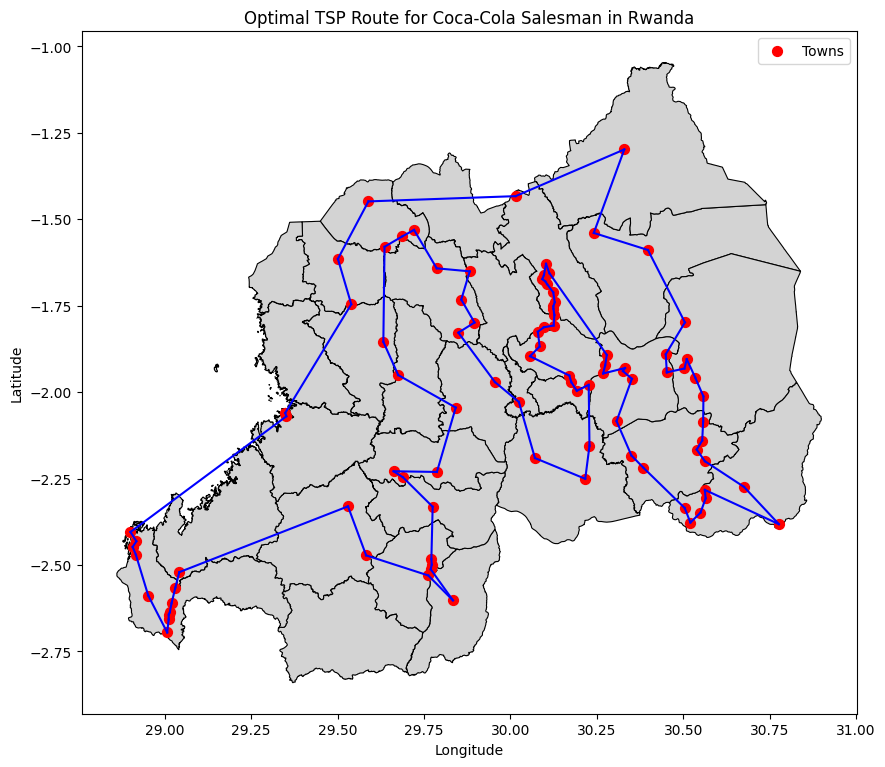

In [15]:
# Visualize the towns, boundary, and optimal route
fig, ax = plt.subplots(figsize=(10, 10))
rwanda_boundary.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.8)
towns.plot(ax=ax, color="red", markersize=50, label="Towns")

# Plot the optimal route
for i in range(len(optimal_route) - 1):
    town1 = town_coords[optimal_route[i]]
    town2 = town_coords[optimal_route[i + 1]]
    plt.plot([town1[0], town2[0]], [town1[1], town2[1]], color="blue")

# Add labels and title
plt.title("Optimal TSP Route for Coca-Cola Salesman in Rwanda")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Save the plot as a PDF
image_filename = 'optimal_route.pdf'
plt.savefig(image_filename)

# Download the PDF file
from google.colab import files
files.download(image_filename)

# Show the plot
plt.show()